# Work With Standardized Spectral File For ESSP4
Standardized spectra have filenames of the form: `DS#.###_spec_<<inst>>.fits`

For example, the twelfth (012) observation from data set three (3), taken by the HARPS-N instrument will have the file name: `DS3.012_spec_harpsn.fits`

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns

In [2]:
# Specify file name
# (I'll select a random file from a specified data set)

# Specify where all the data set folders (i.e. DS1) are, here saved into "essp_dir" variable
essp_dir =

# Specify data set number
dset_num = 1

# Select a file at random from all files in the data set
file_list = glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*.fits'))
file_name = np.random.choice(file_list)

In [3]:
hdus = fits.open(file_name)
hdus.info()

Filename: /Volumes/Hasbrouck/ceph/ESSP_Solar/4_DataSets/Training/DS1/CCFs/DS1.048_ccfs_expres.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  V_GRID        1 ImageHDU         7   (61,)   float64   
  2  CCF           1 ImageHDU         7   (61,)   float64   
  3  E_CCF         1 ImageHDU         7   (61,)   float64   
  4  ECHELLE_ORDERS    1 ImageHDU         7   (87,)   int64   
  5  OBO_CCF       1 ImageHDU         8   (61, 87)   float64   
  6  OBO_E_CCF     1 ImageHDU         8   (61, 87)   float64   
  7  OBO_RV        1 ImageHDU         7   (87,)   float64   
  8  OBO_E_RV      1 ImageHDU         7   (87,)   float64   


## Plot CCF and Order-by-Order (`obo`) CCFs

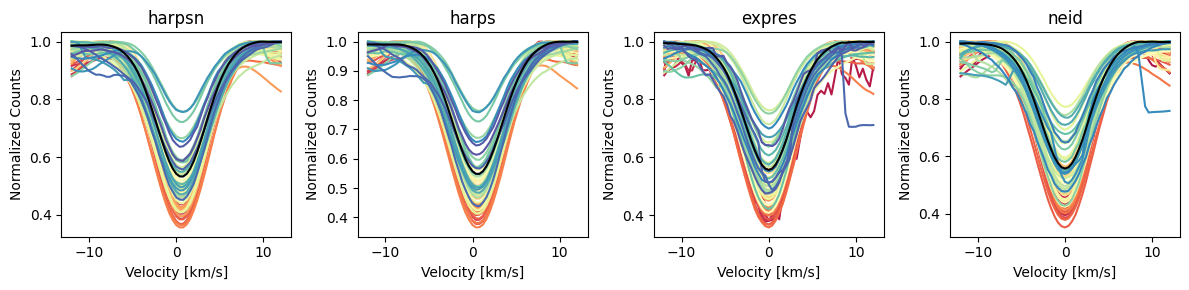

In [4]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*_{inst}.fits')))
    
    # Read in data
    hdus = fits.open(file)
    num_ord = len(hdus['echelle_orders'].data) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use that to define a color map
    v_grid = hdus['v_grid'].data.copy() # velocity grid for all CCFs in the file
    ccf = hdus['ccf'].data.copy()
    obo_ccf = hdus['obo_ccf'].data.copy() # obo CCFs
    hdus.close()
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot Summed/Average CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k')
fig.tight_layout()

## Resample HARPS/HARPS-N CCFs

In [5]:
def resampleCCF(file_name):
    hdus = fits.open(file_name)
    hdu_names = [hdu.name.lower() for hdu in hdus][1:]
    ccf_dict = {}
    for key in hdu_names:
        if key=='echelle_orders':
            data = hdus[key].data
        elif 'obo' in key:
            if 'rv' in key:
                data = hdus[key].data
            else:
                data = hdus[key].data[:,::2]
        else:
            data = hdus[key].data[::2]
        ccf_dict[key] = data.copy()
    return ccf_dict

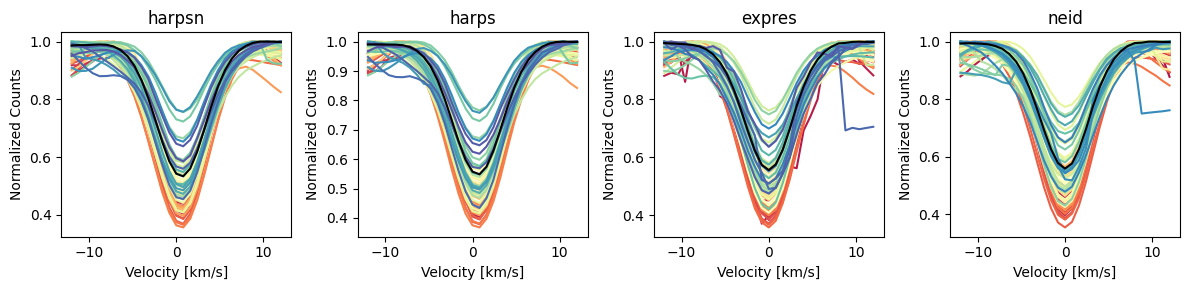

In [6]:
fig, axes = plt.subplots(1,4,figsize=(12,3))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Velocity [km/s]')
    ax.set_ylabel('Normalized Counts')
    # Select a random file
    file = np.random.choice(glob(os.path.join(essp_dir,f'DS{dset_num}','CCFs',f'DS{dset_num}*_{inst}.fits')))
    
    # Read in data
    ccf_dict = resampleCCF(file)
    num_ord = len(ccf_dict['echelle_orders']) # number of orders
    colors = sns.color_palette('Spectral',num_ord) # use that to define a color map
    v_grid = ccf_dict['v_grid'] # velocity grid for all CCFs in the file
    ccf = ccf_dict['ccf']
    obo_ccf = ccf_dict['obo_ccf'] # obo CCFs
    
    # Plot Order-by-Order CCFs
    for nord in range(num_ord):
        if np.sum(np.isfinite(obo_ccf[nord]))==0:
            continue
        ax.plot(v_grid,obo_ccf[nord]/np.nanmax(obo_ccf[nord]),color=colors[nord])
    # Plot Summed/Average CCF
    ax.plot(v_grid,ccf/np.nanmax(ccf),color='k')
fig.tight_layout()